# SH 1st Catboost
## public : 1.0805839044 / private : 1.0415912638 / log_loss: 0.7210969368917933

2nd random forest보다 log_loss 0.06줄어듦 하지만 Dacon 제출했을 때 점수 망.

overfit으로 예상됨. -> 어떻게 줄일 수 있을까?

## develop 
- work_year & work_total의 다중공선성 높기때문에 하나만 채택할 것
- begin_month 반영한 new_age, work 칼럼 생성할 것
- 파생변수 생성!!!!

  

## 필요한 라이브러리 호출

In [93]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from sklearn.preprocessing import OrdinalEncoder


warnings.filterwarnings('ignore')

In [94]:
from sklearn.ensemble import RandomForestClassifier #분류트리(모델) 
from sklearn.model_selection import train_test_split # train/test
from sklearn.metrics import accuracy_score, confusion_matrix # 평가 : 분류정확도 
from sklearn.metrics import classification_report # 평가 : 정확률, 재현율, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

## 데이터 전처리 과정

In [95]:
# 경로 설정 (dataset을 저장하는 경로임.)
path = 'C:/Users/user/Desktop/code/[유비온]신용카드 사용자 연제 예측/'

train = pd.read_csv('{}train.csv'.format(path))
test = pd.read_csv('{}test.csv'.format(path))
submission = pd.read_csv('{}sample_submission.csv'.format(path))

In [65]:
#쓸모없는 칼럼 삭제
for df in (train,test):
    df.drop(['FLAG_MOBIL'], axis=1, inplace=True)   
    df.drop(columns=['index'], inplace=True)
    
del df

### 1. 나이, 고용일자를 이용하여 파생변수 형성

In [63]:
train

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,...,family_size,begin_month,credit,age_year,age_total,work_year,work_total,ID,Nth_card,income_mean
0,F,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,0,1,...,2.0,-24.0,0.0,59,59.42,0,0.00,0.0,3,51750.0
1,F,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,0,1,...,2.0,-28.0,0.0,59,59.42,0,0.00,0.0,2,51750.0
2,F,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,0,1,...,2.0,-30.0,2.0,59,59.42,0,0.00,0.0,1,51750.0
3,F,N,N,103500.0,Pensioner,Higher education,Single / not married,House / apartment,0,0,...,1.0,-17.0,2.0,67,67.17,0,0.00,1.0,2,103500.0
4,F,N,N,103500.0,Pensioner,Higher education,Single / not married,House / apartment,0,0,...,1.0,-39.0,2.0,67,67.17,0,0.00,1.0,1,103500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,M,Y,Y,292500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,...,6.0,-24.0,2.0,38,38.75,1,1.08,8757.0,1,48750.0
26453,M,Y,Y,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,0,0,...,2.0,-19.0,1.0,31,31.17,7,7.42,8758.0,4,101250.0
26454,M,Y,Y,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,0,0,...,2.0,-21.0,1.0,31,31.17,7,7.42,8758.0,3,101250.0
26455,M,Y,Y,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,0,0,...,2.0,-46.0,0.0,31,31.17,7,7.42,8758.0,2,101250.0


In [66]:
# 1st

def year_month_total(df_1, df_2, column, column_name):
    """[나이, 고용연수 파생변수를 생성하기 위한 함수입니다.]

    Args:
        df_1 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        df_2 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        column ([생성할 컬럼의 기준 컬럼 명]): [생성할 컬럼의 기준 컬럼 명을 입력해주세요]
        column_name ([생성할 컬럼의 이름]): [연단위, 연+월단위로 표시된 파생변수 이름입니다.]
    """
    # 변수 설정
    
    df_list = []
    df_list.append(df_1)
    df_list.append(df_2)
    names = ['train', 'test']
    
    # 입력한 컬럼이 DAYS_BIRTH인 경우 If로 처리
    
    if (column == 'DAYS_BIRTH') == True:    
        for dataset,name in zip(df_list,names):
            dataset['DAYS_BIRTH_MOD'] = dataset[column]-dataset['begin_month']*30
            dataset['{}_year'.format(column_name)] = dataset['DAYS_BIRTH_MOD'].abs()//365
            dataset['{}_month'.format(column_name)] = (dataset['DAYS_BIRTH_MOD'].abs()%365)//30
            dataset['{}_total'.format(column_name)] = dataset['{}_year'.format(column_name)] + round(dataset['{}_month'.format(column_name)] * (1/12), 2)
            dataset.drop(columns=['{}_month'.format(column_name)], inplace=True)
        
            print('{0}set에 {1}_year, {1}_total, {2} 컬럼을 생성하였습니다. \n'.format(name,column_name,'DAYS_BIRTH_MOD'))
    
    # 입력한 컬럼이 DAYS_EMPLOYED인 경우 else로 처리 (occyp_type 처리를 위한 작업이므로 1번째로 수행)
    
    else:
        for dataset,name in zip(df_list,names):
            dataset['DAYS_EMPLOYED_MOD'] = dataset['DAYS_EMPLOYED']-dataset['begin_month']*30
            plus_num = dataset[dataset.loc[:,'DAYS_EMPLOYED_MOD']>0].DAYS_EMPLOYED_MOD
            for i in plus_num.unique():
                dataset['DAYS_EMPLOYED_MOD'] = dataset.loc[:,'DAYS_EMPLOYED_MOD'].replace(i, 0)
            
            print('{}set에 근무일자가 잘못기입된 '.format(name) +
                  '\033[96m' + '{} cases'.format(len(dataset[dataset['DAYS_EMPLOYED']>=0])) + 
                  '\033[0m' + '에 대한 처리를 시작합니다.')
            dataset['DAYS_EMPLOYED'] = dataset['DAYS_EMPLOYED'].replace(365243, 0)
            
            dataset['{}_year'.format(column_name)] = dataset['DAYS_EMPLOYED_MOD'].abs()//365
            dataset['{}_month'.format(column_name)] = (dataset['DAYS_EMPLOYED_MOD'].abs()%365)//30
            dataset['{}_total'.format(column_name)] = dataset['{}_year'.format(column_name)] + round(dataset['{}_month'.format(column_name)] * (1/12), 2)
            dataset.drop(columns=['{}_month'.format(column_name)], inplace=True)
        
            print('{0}set에 {1}_year, {1}_total, {2} 컬럼을 생성하였습니다. \n'.format(name,column_name,'DAYS_BIRTH_MOD'))

        
    del df_list,names
    return dataset.head(1)

In [30]:
# 1st

def year_month_total(df_1, df_2, column, column_name):
    """[나이, 고용연수 파생변수를 생성하기 위한 함수입니다.]

    Args:
        df_1 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        df_2 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        column ([생성할 컬럼의 기준 컬럼 명]): [생성할 컬럼의 기준 컬럼 명을 입력해주세요]
        column_name ([생성할 컬럼의 이름]): [연단위, 연+월단위로 표시된 파생변수 이름입니다.]
    """
    # 변수 설정
    
    df_list = []
    df_list.append(df_1)
    df_list.append(df_2)
    names = ['train', 'test']
    
    # 입력한 컬럼이 DAYS_BIRTH인 경우 If로 처리
    
    if (column == 'DAYS_BIRTH') == True:    
        for dataset,name in zip(df_list,names):
            dataset['{}_year'.format(column_name)] = dataset[column].abs()//365
            dataset['{}_month'.format(column_name)] = (dataset[column].abs()%365)//30
            dataset['{}_total'.format(column_name)] = dataset['{}_year'.format(column_name)] + round(dataset['{}_month'.format(column_name)] * (1/12), 2)
            dataset.drop(columns=['{}_month'.format(column_name)], inplace=True)
        
            print('{0}set에 {1}_year, {1}_total 컬럼을 생성하였습니다. \n'.format(name,column_name))
    
    # 입력한 컬럼이 DAYS_EMPLOYED인 경우 else로 처리 (occyp_type 처리를 위한 작업이므로 1번째로 수행)
    
    else:
        for dataset,name in zip(df_list,names):
            print('{}set에 근무일자가 잘못기입된 '.format(name) +
                  '\033[96m' + '{} cases'.format(len(dataset[dataset['DAYS_EMPLOYED']>=0])) + 
                  '\033[0m' + '에 대한 처리를 시작합니다.')
            dataset['DAYS_EMPLOYED'] = dataset['DAYS_EMPLOYED'].replace(365243, 0)
            
            dataset['{}_year'.format(column_name)] = dataset[column].abs()//365
            dataset['{}_month'.format(column_name)] = (dataset[column].abs()%365)//30
            dataset['{}_total'.format(column_name)] = dataset['{}_year'.format(column_name)] + round(dataset['{}_month'.format(column_name)] * (1/12), 2)
            dataset.drop(columns=['{}_month'.format(column_name)], inplace=True)
        
            print('{0}set에 {1}_year, {1}_total 컬럼을 생성하였습니다. \n'.format(name, column_name))
        
    del df_list,names
    return dataset.head(1)

    

In [67]:
year_month_total(train, test,'DAYS_BIRTH','age')

trainset에 age_year, age_total, DAYS_BIRTH_MOD 컬럼을 생성하였습니다. 

testset에 age_year, age_total, DAYS_BIRTH_MOD 컬럼을 생성하였습니다. 



,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,DAYS_BIRTH_MOD,age_year,age_total
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,0,1,0,NaN,2.0,-60.0,-20190.0,55.0,55.25


In [68]:
year_month_total(train, test,'DAYS_EMPLOYED','work')

trainset에 근무일자가 잘못기입된 4438 cases에 대한 처리를 시작합니다.
trainset에 work_year, work_total, DAYS_BIRTH_MOD 컬럼을 생성하였습니다. 

testset에 근무일자가 잘못기입된 1697 cases에 대한 처리를 시작합니다.
testset에 work_year, work_total, DAYS_BIRTH_MOD 컬럼을 생성하였습니다. 



,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,email,occyp_type,family_size,begin_month,DAYS_BIRTH_MOD,age_year,age_total,DAYS_EMPLOYED_MOD,work_year,work_total
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,...,0,NaN,2.0,-60.0,-20190.0,55.0,55.25,0.0,0.0,0.0


### 2. 직업 Nan 값 처리

In [91]:
# 2nd

def occyp_type_nan(df_1, df_2):
    """[직업 컬럼 내의 Nan 값을 처리합니다.]

    Args:
        df_1 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        df_2 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
    """
    # 변수 설정
    
    df_list = []
    df_list.append(df_1)
    df_list.append(df_2)
    names = ['train', 'test']

    # 무직자 처리 함수
    
    for dataset,name in zip(df_list,names):
        dataset['occyp_type'] = dataset['occyp_type'].fillna('Nan')
        
        print('직업 컬럼의 ' +
              '\033[92m' + 'Nan value {}명 중 '.format(len(dataset.loc[dataset['occyp_type'] == 'Nan'])) +
              '\033[96m' + '{}명이 실제 고용일수가 0일입니다. '.format(len(dataset.loc[(dataset['occyp_type'] == 'Nan') & (dataset['DAYS_EMPLOYED'] == 0)])) + 
              '\033[0m'+ '따라서 jobless로 처리합니다.')
        
        dataset.loc[(dataset['occyp_type'] == 'Nan') & (dataset['DAYS_EMPLOYED'] == 0), 'occyp_type'] = 'retired'
        
        # 무직자는 아니지만 데이터가 없는 경우
        
        print('나머지 {}명 데이터는 no_data로 처리합니다.'.format(len(dataset.loc[dataset['occyp_type'] == 'Nan'])))
        
        dataset.loc[dataset['occyp_type'] == 'Nan', 'occyp_type'] = 'no data'
        
        print('{}set의 직업 Nan value를 처리하였습니다.\n'.format(name))
        
    del df_list, names
    return dataset.head(1)

occyp_type_nan(train, test)

직업 컬럼의 Nan value 0명 중 0명이 실제 고용일수가 0일입니다. 따라서 jobless로 처리합니다.
나머지 0명 데이터는 no_data로 처리합니다.
trainset의 직업 Nan value를 처리하였습니다.

직업 컬럼의 Nan value 0명 중 0명이 실제 고용일수가 0일입니다. 따라서 jobless로 처리합니다.
나머지 0명 데이터는 no_data로 처리합니다.
testset의 직업 Nan value를 처리하였습니다.



,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,occyp_type,family_size,begin_month,DAYS_BIRTH_MOD,age_year,age_total,DAYS_EMPLOYED_MOD,work_year,work_total,ID
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,...,jobless,2.0,-60.0,-20190.0,55.0,55.25,0.0,0.0,0.0,M.Y.N.0.112500.0.Pensioner.Secondary / seconda...


### 3. ID컬럼 생성

In [92]:
def ID_col(df_1, df_2):
    """[데이터 셋 전처리 함수입니다.]

    Args:
        df_1 ([Dataset]): [train 데이터셋을 입력해주세요]
        df_2 ([Dataset]): [test 데이터셋을 입력해주세요]
    """
    
    # 변수 설정
     
    df_list = []
    df_list.append(df_1)
    df_list.append(df_2)
    a = []
    change_credit = 0
    names = ['train', 'test']
    
    # ID 생성
    
    for name, dataset, in zip(names, df_list):
    #for dataset in df_list:
        dataset['ID'] = dataset['gender'].astype(str) +'.'+ dataset['car'].astype(str)+'.' + dataset['reality'].astype(str)+'.' + \
                dataset['child_num'].astype(str)+'.' + dataset['income_total'].astype(str) +'.'+ dataset['income_type'].astype(str) +'.'+ \
                dataset['edu_type'].astype(str)+'.' + dataset['family_type'].astype(str)+'.' + dataset['house_type'].astype(str) +'.'+ \
                dataset['DAYS_BIRTH'].astype(str) +'.'+ dataset['DAYS_EMPLOYED'].astype(str) +'.'+ dataset['work_phone'].astype(str) +'.'+ \
                dataset['phone'].astype(str) +'.'+ dataset['email'].astype(str) +'.' + dataset['family_size'].astype(str)+'.' + dataset['occyp_type'].astype(str)
        
        dataset = dataset.sort_values(['ID','begin_month'], ascending=[True, False])
        dataset.reset_index(inplace=True)
        dataset.drop(columns={'index'}, inplace=True)

        # OrdinalEncoder로 ID 변환
        
        print('\033[96m' + '해당 Data 내의 고유 ID 수는 {}입니다. '.format(dataset['ID'].nunique()) + 
              '\033[0m' + 'OrdinalEncoder를 이용힌 변환을 시작합니다.')
        encode = OrdinalEncoder()
        dataset[['ID']] = encode.fit_transform(dataset[['ID']])

        # Nth_card 컬럼 추가 (ID가 같은데 카드 개수가 여러 개인 사람을 대상으로 몇 번째 카드를 만들었는지 생성해준다)
        
        print('Column(Nth_card)을 생성합니다.')
        for i in tqdm(range(dataset['ID'].nunique())):
            Nth_card = len(dataset[dataset['ID']==i]) + 1
            
            while Nth_card > 0:
                Nth_card = Nth_card -1
                a.append(Nth_card)
                if Nth_card == 1:
                    break
                
        dataset['Nth_card'] = a        
        a.clear()
        print('\033[92m' + '신규로 카드를 개설한 사람의 수 : {}'.format(dataset[dataset['begin_month']==0.0]['ID'].nunique()) +
              '\033[0m')
        
        # Credit이 좋아지지 않고 악화된 경우를 체크하는 부분 (begin_month기준으로 Nth_card를 추가해줬으므로 인덱스 값을 기준으로 시행한다.)
        
        if (dataset['ID'].nunique() > 8000)==True:
            print('credit 정보를 확인하고 시간이 지나며 credit이 악화된 사례가 있는지 확인합니다.')
            for i in tqdm(range(dataset['ID'].nunique())):
                num = dataset.loc[dataset['ID'] == i]['credit'].to_list()
                for j in range(len(num)-1):
                    if (num[j] <= num[j+1]) == True:
                        pass
                    else :
                        change_credit += 1
                        break
            print('\033[96m'+'{}명 (전체 인원 중 {:.2f}%)은 credit이 개선되지 않고 악화된 사례가 존재합니다.'.format(change_credit, 
                                                                        (change_credit/dataset['ID'].nunique())*100) + 
                  '\033[0m')  
        else:
            print('\033[96m' + 'credit 정보가 없는 testset입니다.' + 
                  '\033[0m')
        
        # dataset 저장부분
        
        print('dataset(user_list_{})을 저장합니다. \n'.format(name))    
        dataset.to_csv('{}user_list_{}.csv'.format(path, name))
        
    
    del names, a
    return dataset.head(5)

In [71]:
ID_col(train, test)

해당 Data 내의 고유 ID 수는 8759입니다. OrdinalEncoder를 이용힌 변환을 시작합니다.
Column(Nth_card)을 생성합니다.


100%|██████████| 8759/8759 [00:01<00:00, 6041.87it/s]


신규로 카드를 개설한 사람의 수 : 214
credit 정보를 확인하고 시간이 지나며 credit이 악화된 사례가 있는지 확인합니다.


100%|██████████| 8759/8759 [00:01<00:00, 4659.59it/s]


1842명 (전체 인원 중 21.03%)은 credit이 개선되지 않고 악화된 사례가 존재합니다.
dataset(user_list_train)을 저장합니다. 

해당 Data 내의 고유 ID 수는 5585입니다. OrdinalEncoder를 이용힌 변환을 시작합니다.
Column(Nth_card)을 생성합니다.


100%|██████████| 5585/5585 [00:00<00:00, 6752.36it/s]


신규로 카드를 개설한 사람의 수 : 82
credit 정보가 없는 testset입니다.
dataset(user_list_test)을 저장합니다. 



,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,family_size,begin_month,DAYS_BIRTH_MOD,age_year,age_total,DAYS_EMPLOYED_MOD,work_year,work_total,ID,Nth_card
0,F,N,N,0,103500.0,Pensioner,Higher education,Married,House / apartment,-21701,...,2.0,-3.0,-21611.0,59.0,59.17,0.0,0.0,0.0,0.0,3
1,F,N,N,0,103500.0,Pensioner,Higher education,Married,House / apartment,-21701,...,2.0,-46.0,-20321.0,55.0,55.67,0.0,0.0,0.0,0.0,2
2,F,N,N,0,103500.0,Pensioner,Higher education,Married,House / apartment,-21701,...,2.0,-53.0,-20111.0,55.0,55.08,0.0,0.0,0.0,0.0,1
3,F,N,N,0,103500.0,Pensioner,Higher education,Single / not married,House / apartment,-24543,...,1.0,-28.0,-23703.0,64.0,64.92,0.0,0.0,0.0,1.0,1
4,F,N,N,0,103500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-20123,...,2.0,-11.0,-19793.0,54.0,54.17,0.0,0.0,0.0,2.0,2


In [36]:
train = pd.read_csv('{}user_list_train.csv'.format(path))
test = pd.read_csv('{}user_list_test.csv'.format(path))

In [ ]:
dataset.loc[dataset['occyp_type'] == 'Nan']

In [78]:
train.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'occyp_type', 'family_size',
       'begin_month', 'credit', 'DAYS_BIRTH_MOD', 'age_year', 'age_total',
       'DAYS_EMPLOYED_MOD', 'work_year', 'work_total', 'ID'],
      dtype='object')

In [88]:
train.loc[(train['occyp_type'] == 'jobless')]['income_type'].value_counts()

Pensioner    4438
Name: income_type, dtype: int64

In [86]:
train.loc[(train['occyp_type'] == 'no data')]['income_type'].value_counts()

Working                 2312
Commercial associate    1026
State servant            392
Pensioner                  2
Student                    1
Name: income_type, dtype: int64

Pensioner    4449
Name: income_type, dtype: int64

### faimly_size 조정

In [37]:
def replace_value_family(df_1, df_2, num_of_outlier):
    """[Family_size의 outlier를 대치해주는 작업을 시행합니다.]

    Args:
        df_1 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        df_2 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        num_of_outlier ([outlier_standard]): [family_size의 outlier 기준을 입력하세요]
    """
    # 변수 설정
    
    df_list = []
    df_list.append(df_1)
    df_list.append(df_2)
    names = ['train', 'test']

    # family_size Outlier를 처리하는 작업
    
    for dataset,name in zip(df_list,names):
        
        print('family_size와 child_num의 다중공선성 문제로 child_num 컬럼을 삭제해줍니다.')
        
        dataset.drop(columns=['child_num'], inplace=True)
        
        print('\033[96m' + 'family_size {}명 이상인 사람의 수 : {}'.format(num_of_outlier, 
                                                                      len(dataset.loc[dataset['family_size'] >= num_of_outlier])) +
              '\033[0m')
        
        sub = dataset.loc[dataset['family_size']>= num_of_outlier]
        
        for i in tqdm(range(len(sub))):
        
            a = int(dataset[dataset['family_type'] == sub['family_type'].values[i]].mean()['family_size'])
            
            dataset.loc[(dataset['family_size']>= num_of_outlier), 'family_size'] = a
        
        # 잘 처리되었는지 확인하는 부분
        
        print('\033[96m' + 'family_size {}명 이상인 사람의 수 : {}'.format(num_of_outlier, 
                                                        len(dataset.loc[dataset['family_size'] >= num_of_outlier]))+
              '\033[0m')

        # family_size를 조정하고 난 후에 1인당 소득으로 total_income을 scale_down 해줌.
        
        print('1인당 소득으로 소득 수준을 조정합니다.')
        
        dataset['income_mean'] = dataset['income_total'] / dataset['family_size']
        
        print('{} 데이터 셋 처리 완료.\n'.format(name))
    
    del sub,df_list, names
    return dataset.head(1)

replace_value_family(train, test, 7)

family_size와 child_num의 다중공선성 문제로 child_num 컬럼을 삭제해줍니다.
family_size 7명 이상인 사람의 수 : 15


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


family_size 7명 이상인 사람의 수 : 0
1인당 소득으로 소득 수준을 조정합니다.
train 데이터 셋 처리 완료.

family_size와 child_num의 다중공선성 문제로 child_num 컬럼을 삭제해줍니다.
family_size 7명 이상인 사람의 수 : 10


100%|██████████| 10/10 [00:00<00:00, 17.50it/s]

family_size 7명 이상인 사람의 수 : 0
1인당 소득으로 소득 수준을 조정합니다.
test 데이터 셋 처리 완료.



,Unnamed: 0,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,occyp_type,family_size,begin_month,age_year,age_total,work_year,work_total,ID,Nth_card,income_mean
0,0,F,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,-21701,...,jobless,2.0,-3.0,59,59.42,0,0.0,0.0,3,51750.0


In [38]:
names = ['train', 'test']

for name,dataset in zip(names, [train, test]):
    dataset.drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED','Unnamed: 0'], inplace=True)
    dataset.to_csv('{}final_set_{}.csv'.format(path,name))

### AGE, WORK에 BEGIN_MONTH 반영한 새로운 칼럼 추가

In [39]:
train.head(1)

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,...,family_size,begin_month,credit,age_year,age_total,work_year,work_total,ID,Nth_card,income_mean
0,F,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,0,1,...,2.0,-24.0,0.0,59,59.42,0,0.0,0.0,3,51750.0


In [15]:
# train['age_new'] = train['age_total'] - abs(train['begin_month']//12)
#train.drop(columns=['age_new'],inplace=True)

In [ ]:
# def month_total = 
#     for dataset,name in zip(df_list,names):
#         dataset['{}_year'.format(column_name)] = dataset[column].abs()//365
#         dataset['{}_month'.format(column_name)] = (dataset[column].abs()%365)//30
#         dataset['{}_total'.format(column_name)] = dataset['{}_year'.format(column_name)] + round(dataset['{}_month'.format(column_name)] * (1/12), 2)
#         dataset.drop(columns=['{}_month'.format(column_name)], inplace=True)

## MinMaxScaler
catboost는 int, object만 허용 
민멕스 스캐일 의미없음 그래서 1등코드는 로그스케일 쓴거임 치밀한 넘들ㅜ
age total도 노의미 age_year만 데리고 간다

In [109]:
#train minmaxscaler income_total
from sklearn.preprocessing import MinMaxScaler
income_total = pd.DataFrame(train, columns=['income_total'])
scaler = MinMaxScaler()
scaler.fit(income_total)
train['scaler_income'] = scaler.transform(income_total)
#train minmaxscaler income_mean
income_mean = pd.DataFrame(train, columns=['income_mean'])
scaler = MinMaxScaler()
scaler.fit(income_mean)
train['scaler_income_mean'] = scaler.transform(income_mean)

In [110]:
#test minmaxscaler income_total
income_total = pd.DataFrame(test, columns=['income_total'])
scaler = MinMaxScaler()
scaler.fit(income_total)
test['scaler_income'] = scaler.transform(income_total)
#test minmaxscaler income_mean
income_mean = pd.DataFrame(test, columns=['income_mean'])
scaler = MinMaxScaler()
scaler.fit(income_mean)
test['scaler_income_mean'] = scaler.transform(income_mean)

In [111]:
train.drop(columns=['income_total', 'income_mean'],inplace=True)
test.drop(columns=['income_total', 'income_mean'],inplace=True)

## StandardScaler

In [ ]:
#numerical_feats.remove('income_total')
#numerical_feats.remove('credit')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

## MODELING - Catboost

In [19]:
#타입 구분
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
print("Number of Numerical features: ", (numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

float_feats = train.dtypes[train.dtypes == "float"].index.tolist()
print("Number of float features: ", len(float_feats))

Number of Numerical features:  ['income_total', 'work_phone', 'phone', 'email', 'family_size', 'begin_month', 'credit', 'age_year', 'age_total', 'work_year', 'work_total', 'ID', 'Nth_card', 'income_mean']
Number of Categorical features:  8
Number of float features:  8


In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        10000 non-null  float64
 1   car           10000 non-null  float64
 2   reality       10000 non-null  float64
 3   income_total  10000 non-null  float64
 4   income_type   10000 non-null  float64
 5   edu_type      10000 non-null  float64
 6   family_type   10000 non-null  float64
 7   house_type    10000 non-null  float64
 8   work_phone    10000 non-null  int64  
 9   phone         10000 non-null  int64  
 10  email         10000 non-null  int64  
 11  occyp_type    10000 non-null  float64
 12  family_size   10000 non-null  float64
 13  begin_month   10000 non-null  float64
 14  age_year      10000 non-null  int64  
 15  age_total     10000 non-null  float64
 16  work_year     10000 non-null  int64  
 17  work_total    10000 non-null  float64
 18  ID            10000 non-nul

In [20]:
#train object 인코딩
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
train[categorical_feats] = encoder.fit_transform(train[categorical_feats])
#train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
#test 인코딩
test[categorical_feats] = encoder.fit_transform(test[categorical_feats])



In [105]:
# numerical_feats.remove('credit')
# numerical_feats

['work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'age_year',
 'age_total',
 'work_year',
 'work_total',
 'ID',
 'Nth_card',
 'income_mean']

In [23]:
train

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,...,family_size,begin_month,credit,age_year,age_total,work_year,work_total,ID,Nth_card,income_mean
0,0.0,0.0,0.0,103500.0,1.0,1.0,1.0,1.0,0,1,...,2.0,-24.0,0.0,59,59.42,0,0.00,0.0,3,51750.0
1,0.0,0.0,0.0,103500.0,1.0,1.0,1.0,1.0,0,1,...,2.0,-28.0,0.0,59,59.42,0,0.00,0.0,2,51750.0
2,0.0,0.0,0.0,103500.0,1.0,1.0,1.0,1.0,0,1,...,2.0,-30.0,2.0,59,59.42,0,0.00,0.0,1,51750.0
3,0.0,0.0,0.0,103500.0,1.0,1.0,3.0,1.0,0,0,...,1.0,-17.0,2.0,67,67.17,0,0.00,1.0,2,103500.0
4,0.0,0.0,0.0,103500.0,1.0,1.0,3.0,1.0,0,0,...,1.0,-39.0,2.0,67,67.17,0,0.00,1.0,1,103500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,1.0,1.0,1.0,292500.0,4.0,4.0,1.0,1.0,0,0,...,6.0,-24.0,2.0,38,38.75,1,1.08,8757.0,1,48750.0
26453,1.0,1.0,1.0,202500.0,4.0,4.0,1.0,0.0,0,0,...,2.0,-19.0,1.0,31,31.17,7,7.42,8758.0,4,101250.0
26454,1.0,1.0,1.0,202500.0,4.0,4.0,1.0,0.0,0,0,...,2.0,-21.0,1.0,31,31.17,7,7.42,8758.0,3,101250.0
26455,1.0,1.0,1.0,202500.0,4.0,4.0,1.0,0.0,0,0,...,2.0,-46.0,0.0,31,31.17,7,7.42,8758.0,2,101250.0


In [ ]:
train

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        26457 non-null  object 
 1   car           26457 non-null  object 
 2   reality       26457 non-null  object 
 3   income_total  26457 non-null  float64
 4   income_type   26457 non-null  object 
 5   edu_type      26457 non-null  object 
 6   family_type   26457 non-null  object 
 7   house_type    26457 non-null  object 
 8   work_phone    26457 non-null  int64  
 9   phone         26457 non-null  int64  
 10  email         26457 non-null  int64  
 11  occyp_type    26457 non-null  object 
 12  family_size   26457 non-null  float64
 13  begin_month   26457 non-null  float64
 14  credit        26457 non-null  float64
 15  age_year      26457 non-null  int64  
 16  age_total     26457 non-null  float64
 17  work_year     26457 non-null  int64  
 18  work_total    26457 non-nu

In [23]:
# #train, test x,y 설정
# train_x=train.drop('credit', axis=1)
# train_y=train[['credit']]
# test_x=test
# print(train_x.shape, train_y.shape, test.shape)

(26457, 21) (26457, 1) (10000, 21)


In [44]:
train

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,...,family_size,begin_month,credit,age_year,age_total,work_year,work_total,ID,Nth_card,income_mean
0,F,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,0,1,...,2.0,-24.0,0.0,59,59.42,0,0.00,0.0,3,51750.0
1,F,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,0,1,...,2.0,-28.0,0.0,59,59.42,0,0.00,0.0,2,51750.0
2,F,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,0,1,...,2.0,-30.0,2.0,59,59.42,0,0.00,0.0,1,51750.0
3,F,N,N,103500.0,Pensioner,Higher education,Single / not married,House / apartment,0,0,...,1.0,-17.0,2.0,67,67.17,0,0.00,1.0,2,103500.0
4,F,N,N,103500.0,Pensioner,Higher education,Single / not married,House / apartment,0,0,...,1.0,-39.0,2.0,67,67.17,0,0.00,1.0,1,103500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,M,Y,Y,292500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,...,6.0,-24.0,2.0,38,38.75,1,1.08,8757.0,1,48750.0
26453,M,Y,Y,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,0,0,...,2.0,-19.0,1.0,31,31.17,7,7.42,8758.0,4,101250.0
26454,M,Y,Y,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,0,0,...,2.0,-21.0,1.0,31,31.17,7,7.42,8758.0,3,101250.0
26455,M,Y,Y,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,0,0,...,2.0,-46.0,0.0,31,31.17,7,7.42,8758.0,2,101250.0


In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        26457 non-null  object 
 1   car           26457 non-null  object 
 2   reality       26457 non-null  object 
 3   income_total  26457 non-null  float64
 4   income_type   26457 non-null  object 
 5   edu_type      26457 non-null  object 
 6   family_type   26457 non-null  object 
 7   house_type    26457 non-null  object 
 8   work_phone    26457 non-null  int64  
 9   phone         26457 non-null  int64  
 10  email         26457 non-null  int64  
 11  occyp_type    26457 non-null  object 
 12  family_size   26457 non-null  float64
 13  begin_month   26457 non-null  float64
 14  credit        26457 non-null  float64
 15  age_year      26457 non-null  int64  
 16  age_total     26457 non-null  float64
 17  work_year     26457 non-null  int64  
 18  work_total    26457 non-nu

In [119]:
train.drop(columns=['age_total', 'work_total'],inplace=True)
test.drop(columns=['age_total', 'work_total'],inplace=True)

# MODELING

## CATBOOST-5위

In [46]:
train_x = train.drop(['credit'],axis=1)
train_y = train['credit']

In [47]:
# object형 변수는 cat_features에 추가
cat_features = [f for f in train_x.columns if train_x[f].dtype == 'object']

def column_index(df, cat_features):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, cat_features, sorter=sidx)]

cat_features_idx = column_index(train_x, cat_features)    
print("Cat features are: %s" % [f for f in cat_features])
print(cat_features_idx)

Cat features are: ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']
[ 0  1  2  4  5  6  7 11]


In [54]:
cat = CatBoostClassifier()

In [48]:
cat_models={}

def cat_kfold(max_depth, learning_rate, random_seed):
    
    folds=StratifiedKFold(n_splits=10, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test.shape[0], 3))  
    
    for seed in random_seed:
        for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
            print(f'===================================={n_fold+1}============================================')
            
            X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
            y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

            # early_stopping 50에서 가장 좋은 점수를 내는 learning_rate를 활용
            cat = CatBoostClassifier(n_estimators=3000, max_depth=max_depth, random_seed=seed, learning_rate=learning_rate, bootstrap_type ='Bernoulli')
            cat.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=50, cat_features=cat_features,
                  verbose=100)

            cat_models[n_fold] = cat

            # val 데이터 예측
            predictions = cat.predict_proba(X_val)
            # test 데이터 예측
            test_predictions = cat.predict_proba(test)

            # val 데이터 예측 logloss 값 저장
            logloss=log_loss(to_categorical(y_val), predictions)
            outcomes.append(logloss)
            print(f"FOLD {n_fold+1} : logloss:{logloss}")

            # test 데이터 예측 결과 종합
            # 최종 적으로는 kolds 횟수 만큼 나눠서 평균 값을 활용
            sub+=test_predictions

            print(f'================================================================================\n\n')

    # 저장된 val 데이터 예측 logloss 값의 평균 값으로 성능을 비교
    mean_outcome=np.mean(outcomes)
    print("Mean:{}".format(mean_outcome))
    
    return sub/(folds.n_splits * len(random_seed))

In [49]:
my_submission = cat_kfold(8, 0.04, [1042])

====================================1============================================
0:	learn: 1.0758600	test: 1.0758600	test1: 1.0760423	best: 1.0760423 (0)	total: 268ms	remaining: 13m 22s
100:	learn: 0.7982940	test: 0.8000113	test1: 0.8060417	best: 0.8060417 (100)	total: 7.84s	remaining: 3m 45s
200:	learn: 0.7816413	test: 0.7877395	test1: 0.7992958	best: 0.7992958 (200)	total: 16.1s	remaining: 3m 44s
300:	learn: 0.7578789	test: 0.7683121	test1: 0.7896336	best: 0.7896336 (300)	total: 24.7s	remaining: 3m 41s
400:	learn: 0.7298641	test: 0.7427034	test1: 0.7788459	best: 0.7788459 (400)	total: 33.8s	remaining: 3m 38s
500:	learn: 0.7053395	test: 0.7211380	test1: 0.7698896	best: 0.7698896 (500)	total: 42.8s	remaining: 3m 33s
600:	learn: 0.6860970	test: 0.7064238	test1: 0.7660932	best: 0.7660932 (600)	total: 51.9s	remaining: 3m 26s
700:	learn: 0.6656149	test: 0.6889420	test1: 0.7604169	best: 0.7604169 (700)	total: 1m 1s	remaining: 3m 20s
800:	learn: 0.6475673	test: 0.6739943	test1: 0.7561010	be

In [50]:
my_submission

array([[0.18605952, 0.79164057, 0.02229991],
       [0.10345614, 0.25554016, 0.6410037 ],
       [0.09457083, 0.17985547, 0.7255737 ],
       ...,
       [0.14878793, 0.17662554, 0.67458653],
       [0.16329489, 0.20093578, 0.63576932],
       [0.16419716, 0.16160908, 0.67419376]])

In [60]:
# 특성 중요도 시각화
import seaborn as sns
feature_names = list(train_x.columns)
sns.barplot(cat.feature_importances_, y=feature_names)

AttributeError: 'CatBoostClassifier' object has no attribute 'cat_features'

In [58]:
submission.loc[:,1:]=my_submission
submission.to_csv('1103_catboost_1st.csv', index = False)

In [59]:
submission

,index,0,1,2
0,26457,0.186060,0.791641,0.022300
1,26458,0.103456,0.255540,0.641004
2,26459,0.094571,0.179855,0.725574
3,26460,0.171706,0.111144,0.717151
4,26461,0.037303,0.071887,0.890809
...,...,...,...,...
9995,36452,0.112609,0.235557,0.651833
9996,36453,0.198371,0.790315,0.011314
9997,36454,0.148788,0.176626,0.674587
9998,36455,0.163295,0.200936,0.635769


## CATBOOST-1위-> 안돌아감 좀 더 확인할 것

In [42]:
n_est = 2000
seed = 42
n_fold = 5
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test
model_cat = CatBoostClassifier()

In [ ]:
# # 특성 중요도 시각화
# import seaborn as sns
# feature_names = list(train_x.columns)
# sns.barplot(clf.feature_importances_, y=feature_names)

In [ ]:
# # 모델 학습
cat_clf=CatBoostClassifier()
cat_clf.fit(X_train, y_train)
y_pred=cat_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(cat_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(cat_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

In [62]:
cat_features

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type']

In [43]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')



----------------- Fold 0 -----------------



CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="F": Cannot convert 'b'F'' to float

In [51]:
train

,gender,car,reality,income_type,edu_type,family_type,house_type,work_phone,phone,email,...,begin_month,credit,age_year,age_total,work_year,work_total,ID,Nth_card,scaler_income,scaler_income_mean
0,0,0,0,1,1,1,1,0,1,0,...,-24,0,59,59,0,0,0,3,0,0
1,0,0,0,1,1,1,1,0,1,0,...,-28,0,59,59,0,0,0,2,0,0
2,0,0,0,1,1,1,1,0,1,0,...,-30,2,59,59,0,0,0,1,0,0
3,0,0,0,1,1,3,1,0,0,0,...,-17,2,67,67,0,0,1,2,0,0
4,0,0,0,1,1,3,1,0,0,0,...,-39,2,67,67,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,1,1,1,4,4,1,1,0,0,0,...,-24,2,38,38,1,1,8757,1,0,0
26453,1,1,1,4,4,1,0,0,0,0,...,-19,1,31,31,7,7,8758,4,0,0
26454,1,1,1,4,4,1,0,0,0,0,...,-21,1,31,31,7,7,8758,3,0,0
26455,1,1,1,4,4,1,0,0,0,0,...,-46,0,31,31,7,7,8758,2,0,0


# Random Forest

<AxesSubplot:>

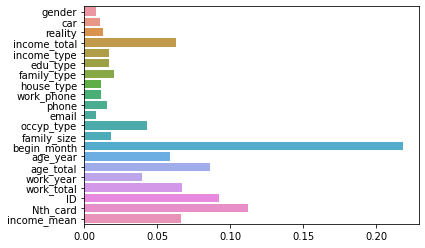

In [27]:
# 특성 중요도 시각화
import seaborn as sns
feature_names = list(train_x.columns)
sns.barplot(clf.feature_importances_, y=feature_names)

In [25]:
#train, test x,y 설정
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test
print(train_x.shape, train_y.shape, test.shape)

(26457, 21) (26457, 1) (10000, 21)


In [26]:
#Random Forest model fit
from sklearn.ensemble import RandomForestClassifier #분류트리(모델) 
from sklearn.model_selection import train_test_split # train/test
from sklearn.metrics import accuracy_score, confusion_matrix # 평가 : 분류정확도 
from sklearn.metrics import classification_report # 평가 : 정확률, 재현율, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.30,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


clf=RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(18519, 21)
(18519, 1)
Validation set: 
(7938, 21)
(7938, 1)
log_loss: 0.7845305635744351


In [25]:
#Run KFOLD
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

FOLD 0 : logloss:0.743955637255262
FOLD 1 : logloss:0.7666589203410648
FOLD 2 : logloss:0.7564283837489225
FOLD 3 : logloss:0.7900846740971309
FOLD 4 : logloss:0.7743613748051061
Mean:0.7662977980494972


In [26]:
my_submission

array([[0.228, 0.712, 0.06 ],
       [0.414, 0.178, 0.408],
       [0.206, 0.11 , 0.684],
       ...,
       [0.136, 0.3  , 0.564],
       [0.266, 0.196, 0.538],
       [0.314, 0.142, 0.544]])

In [28]:
submission.loc[:,1:]=my_submission
submission.to_csv('1102_scale_1.csv', index = False)

In [29]:
my_submission

array([[0.228, 0.712, 0.06 ],
       [0.414, 0.178, 0.408],
       [0.206, 0.11 , 0.684],
       ...,
       [0.136, 0.3  , 0.564],
       [0.266, 0.196, 0.538],
       [0.314, 0.142, 0.544]])

In [139]:
train.to_pickle('data.pkl')

# lightgbm 

In [140]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
warnings.filterwarnings('ignore')
sns.set(style = 'whitegrid')
pd.set_option('display.max_columns', 50)
np.random.seed(2018)

In [141]:
%time
df = pd.read_pickle(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\data.pkl').reset_index(drop = True)

# learning
trn = df[df.credit.notna()]
tst = df[df.credit.isna()].drop('credit', axis = 1)
print(trn.shape, tst.shape)

tst_preds_lgbm, feat_im_lgbm = train_model(LGBMClassifier(**lgbm_params), trn, tst, cv = 20)
tst_preds_xgb, feat_im_xgb = train_model(XGBClassifier(**xgb_params), trn, tst, cv = 20)

Wall time: 0 ns
(26457, 20) (0, 19)


NameError: name 'train_model' is not defined